In [9]:
from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
from matplotlib import pyplot
from mlxtend.feature_selection import SequentialFeatureSelector as sfbs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfbs
from numpy import *
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from numpy.random import seed
from pandas import read_csv
from random import randint
from random import random
from random import seed
from scipy import stats # For in-built method to get PCC
from sklearn import linear_model
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.stats.outliers_influence import OLSInfluence
from tqdm import tnrange, tqdm_notebook
from zca import zca
import itertools
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import pingouin as pg
import scipy
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
#import random

y_train_scaler = StandardScaler()
x_train_inter_scaler = StandardScaler()
zca = zca.ZCA()

In [10]:
numCV = 5
kfold = KFold(n_splits=numCV, shuffle=True)
p_threshold = .05
divisor = .2
target = 'Poverty'
exclude = 'States'

cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
l1s = arange(0, 1, 0.01/divisor)

seed_ = 3

#random.seed(11)

seed(seed_)

In [11]:
# evaluate a model
def evaluate_model(X, y, model):
	# define model evaluation method
	cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
	# force scores to be positive
	return absolute(scores)

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
	# fut the model on all data
	model.fit(X, y)
	# plot the dataset
	pyplot.scatter(X, y)
	# plot the line of best fit
	xaxis = arange(X.min(), X.max(), 0.01)
	yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
	pyplot.plot(xaxis, yaxis, color='r')
	# show the plot
	pyplot.title(type(model).__name__)
	pyplot.show()

In [12]:
all_data = pd.read_csv('../data/raw/states.csv')

In [13]:

train, valid = train_test_split(all_data.index, test_size=0.3, shuffle=True)
valid, test = train_test_split(valid,  test_size=0.5, shuffle=True)

X = all_data[set(all_data.columns).difference([target,exclude])].copy()
y = pd.DataFrame(all_data[target].copy())

X_train = X.loc[train].copy()
X_valid = X.loc[valid].copy()
X_test = X.loc[test].copy()

y_train = y.loc[X_train.index][[target]].copy()
y_valid = y.loc[X_valid.index][[target]].copy()
y_test = y.loc[X_test.index][[target]].copy()

y_train_scaler.fit(np.array(y_train).reshape(-1, 1))

#pd.DataFrame([i[0] for i in scaler.transform(np.array(y_train).reshape(-1, 1))])

StandardScaler()

In [14]:
ss_X_train = StandardScaler()
ss_X_train_scale_fit = ss_X_train.fit(X_train)
ss_X_train_fit = ss_X_train_scale_fit.transform(X_train)
print(ss_X_train_scale_fit.scale_)
print(ss_X_train_scale_fit.mean_)

pt = PowerTransformer(standardize=False)
pt_X_train_fit = pt.fit(ss_X_train_fit)
print(pt_X_train_fit.lambdas_)
pt_X_train = pd.DataFrame(pt_X_train_fit.transform(ss_X_train_fit),index=X_train.index,columns=X_train.columns)
#inverse
#pd.DataFrame(ss_X_train_fit.inverse_transform(pt_X_train_fit.inverse_transform(pt_X_train)),index=X_train.index,columns=X_train.columns)


[4.63274944e+00 6.54981836e+01 3.78690547e-01 8.02156530e+03
 1.44643122e+00 1.20838567e+00 7.38008648e+06 1.56166045e+02
 1.23989117e+01]
[2.72857143e+01 2.66222857e+02 1.37857143e+00 5.18252571e+04
 6.75714286e+00 5.24571429e+00 7.22442783e+06 3.89771429e+02
 8.11885714e+01]
[ 0.69149678  0.29652402  0.63390953  0.53394959  0.50184777  1.07305312
 -0.36102862  0.42859363  1.98564095]


In [15]:
ss_y_train = StandardScaler()
ss_y_train_scale_fit = ss_y_train.fit(y_train)
ss_y_train_fit = ss_y_train_scale_fit.transform(y_train)
print(ss_y_train_scale_fit.scale_)
print(ss_y_train_scale_fit.mean_)

pt = PowerTransformer(standardize=False)
pt_y_train_fit = pt.fit(ss_y_train_fit)
print(pt_y_train_fit.lambdas_)
pt_y_train = pd.DataFrame(pt_y_train_fit.transform(ss_y_train_fit),index=y_train.index,columns=y_train.columns)

[2.81767888]
[12.98]
[0.60421595]


In [16]:
import sklearn
from sklearn.preprocessing import *

interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

x_train_inter = pd.DataFrame(interaction.fit_transform(pt_X_train),index=pt_X_train.index,columns=interaction.get_feature_names(input_features=pt_X_train.columns))

In [17]:
lr = LinearRegression()

#backwards step subset
sfbs1 = sfbs(lr, 
          k_features=len(x_train_inter.columns), 
          #forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=numCV)
            
sfbs1 = sfbs1.fit(x_train_inter, pt_y_train)


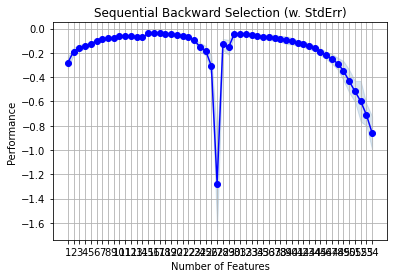

In [18]:
fig = plot_sfbs(sfbs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Backward Selection (w. StdErr)')
plt.grid()
plt.show()

In [19]:
features = list(pd.DataFrame(sfbs1.subsets_).loc['feature_names'].values)

In [20]:
ss_position = np.array(pd.DataFrame(pd.DataFrame(sfbs1.subsets_)).loc['avg_score']).argmax()

In [21]:
pd.DataFrame(sfbs1.subsets_).T[['avg_score','feature_names']]

,avg_score,feature_names
1,-0.28052,"(Income,)"
2,-0.189609,"(Income, Population)"
3,-0.15561,"(Income, Population, Unemployed Crime)"
4,-0.145352,"(Income, Population, Infant Mort Unemployed, U..."
5,-0.127003,"(Income, Population, White, Infant Mort Unempl..."
6,-0.101178,"(Income, Infant Mort, Population, White, Infan..."
7,-0.085202,"(Income, Infant Mort, Population, White, Infan..."
8,-0.079926,"(Income, Infant Mort, Population, White, Infan..."
9,-0.079613,"(Income, Infant Mort, Population, White, Incom..."
10,-0.063185,"(Income, Infant Mort, Crime, White, Doctors In..."


In [22]:
ss_sortedFeatures = list(np.array(pd.DataFrame(sfbs1.subsets_).loc['feature_names'])[ss_position])

In [23]:
CV_results = pd.DataFrame()#[]#np.zeros(shape=(len(features),5))

#looping over sequentially selected features, deriving ElasticNet hyper parm's over each best subset and noting error

for f in features:

    print(f)
    cv = RepeatedKFold(n_splits=numCV, n_repeats=1, random_state=1)

    EN_CV = ElasticNetCV(l1_ratio=l1s, alphas=alphas, cv=cv, n_jobs=-1)
    # fit model

    X_subset = pd.DataFrame(x_train_inter[list(np.asarray(f))])
    y_ = pt_y_train
    EN_CV.fit(X_subset, y_)
    
    print('alpha: %f' % EN_CV.alpha_)
    print('l1_ratio_: %f' % EN_CV.l1_ratio_)
    
    # evaluate model
    scores = cross_val_score(EN_CV, X_subset, y_, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    
    temp = pd.concat([pd.DataFrame({"features": [np.array(f)]}),pd.DataFrame(np.array(mean(scores)).reshape(-1,1)),pd.DataFrame(np.array(std(scores)).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.alpha_).reshape(-1,1)),pd.DataFrame(np.array(EN_CV.l1_ratio_).reshape(-1,1))],axis=1)
    
    CV_results = pd.concat([CV_results,temp],axis=0)

('Income',)
alpha: 0.001000
l1_ratio_: 0.000000
Mean MAE: 0.401 (0.128)
('Income', 'Population')
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.366 (0.053)
('Income', 'Population', 'Unemployed Crime')
alpha: 0.010000
l1_ratio_: 0.000000
Mean MAE: 0.325 (0.019)
('Income', 'Population', 'Infant Mort Unemployed', 'Unemployed Crime')
alpha: 0.010000
l1_ratio_: 0.200000
Mean MAE: 0.338 (0.036)
('Income', 'Population', 'White', 'Infant Mort Unemployed', 'Unemployed Crime')
alpha: 0.010000
l1_ratio_: 0.650000
Mean MAE: 0.287 (0.039)
('Income', 'Infant Mort', 'Population', 'White', 'Infant Mort Unemployed', 'Unemployed Crime')
alpha: 0.000000
l1_ratio_: 0.350000
Mean MAE: 0.252 (0.029)
('Income', 'Infant Mort', 'Population', 'White', 'Infant Mort Unemployed', 'Unemployed Crime', 'Population White')
alpha: 0.001000
l1_ratio_: 0.800000
Mean MAE: 0.252 (0.043)
('Income', 'Infant Mort', 'Population', 'White', 'Infant Mort Unemployed', 'Unemployed Population', 'Unemployed Crime', 'Population White

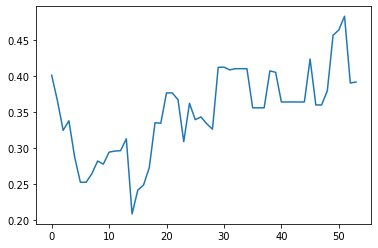

['Income' 'Infant Mort' 'Unemployed' 'Population' 'White'
 'University Traf Deaths' 'University Infant Mort' 'University Crime'
 'Doctors^2' 'Doctors Infant Mort' 'Doctors Population'
 'Traf Deaths Unemployed' 'Income Infant Mort' 'Income White'
 'Infant Mort Population']
['Income' 'Infant Mort' 'Population' 'White' 'Infant Mort Unemployed'
 'Unemployed Crime']


,features,mean error,std,alpha,lambda
0,[Income],0.401273,0.127597,0.0010,0.00
1,"[Income, Population]",0.365838,0.052789,0.0100,0.00
2,"[Income, Population, Unemployed Crime]",0.324555,0.019155,0.0100,0.00
3,"[Income, Population, Infant Mort Unemployed, U...",0.337826,0.036052,0.0100,0.20
4,"[Income, Population, White, Infant Mort Unempl...",0.287341,0.038834,0.0100,0.65
5,"[Income, Infant Mort, Population, White, Infan...",0.252153,0.028817,0.0000,0.35
6,"[Income, Infant Mort, Population, White, Infan...",0.252254,0.043295,0.0010,0.80
7,"[Income, Infant Mort, Population, White, Infan...",0.264088,0.056442,0.0010,0.55
8,"[Income, Infant Mort, Population, White, Incom...",0.281787,0.039698,0.0100,0.25
9,"[Income, Infant Mort, Crime, White, Doctors In...",0.277430,0.055399,0.0100,0.00


In [24]:
CV_results.columns = ['features','mean error','std','alpha','lambda']
CV_results.index = np.array(range(0,len(features)))#range(1,len(features)+1)
plt.plot(CV_results['mean error'])
plt.show()

best = CV_results.iloc[CV_results['mean error'].idxmin()]
print(best.loc['features'])

parse = CV_results[CV_results['mean error']<=(np.min(CV_results['mean error'])+np.std(CV_results['mean error']))].iloc[0]
print(parse.loc['features'])
display(CV_results)

In [25]:
ss_sortedFeatures

['Income',
 'Infant Mort',
 'Unemployed',
 'Population',
 'White',
 'University Traf Deaths',
 'University Infant Mort',
 'University Crime',
 'Doctors^2',
 'Doctors Infant Mort',
 'Doctors Population',
 'Traf Deaths Unemployed',
 'Income Infant Mort',
 'Income White',
 'Infant Mort Population']

In [26]:
model_ss = LinearRegression()
model_ep = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])
model_eb = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

model_ss.fit(x_train_inter[ss_sortedFeatures], pt_y_train)
model_ep.fit(x_train_inter[parse['features']],pt_y_train)
model_eb.fit(x_train_inter[best['features']],pt_y_train)

ElasticNet(alpha=0.0001, l1_ratio=0.0)

In [27]:
zca_X_train = pd.DataFrame(zca.fit_transform(x_train_inter[ss_sortedFeatures]),columns=ss_sortedFeatures)
zca_X_train.index = x_train_inter.index
zca_data = pd.concat([pt_y_train,zca_X_train],axis=1)
zca_data.index = x_train_inter.index

In [28]:
pca_X_train = PCA(n_components=0.99, svd_solver='full')
pca_X_train.fit(x_train_inter[ss_sortedFeatures])
X_pca_train = pd.DataFrame(pca_X_train.transform(x_train_inter[ss_sortedFeatures]),index = x_train_inter.index)

In [29]:
#zca_data.pcorr()

In [30]:
#sns.pairplot(zca_data,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [31]:
pca_X_train.explained_variance_ratio_.cumsum()

array([0.33020633, 0.49150979, 0.62712881, 0.71192862, 0.79018   ,
       0.84255898, 0.8840003 , 0.92113466, 0.94077183, 0.95922621,
       0.97469399, 0.98419914, 0.99237256])

In [32]:
len(ss_sortedFeatures)

15

In [33]:
print(ss_sortedFeatures)

['Income', 'Infant Mort', 'Unemployed', 'Population', 'White', 'University Traf Deaths', 'University Infant Mort', 'University Crime', 'Doctors^2', 'Doctors Infant Mort', 'Doctors Population', 'Traf Deaths Unemployed', 'Income Infant Mort', 'Income White', 'Infant Mort Population']


In [34]:
#model = sklearn.linear_model.LinearRegression()
#data_set_wConstant = statsmodels.tools.tools.add_constant(zca_data)
data_set_wConstant = statsmodels.tools.tools.add_constant(X_pca_train)
#y_ = data_set_wConstant[target]
#data_set_wConstant = data_set_wConstant[data_set_wConstant.columns.drop(target)]
#results = model.fit(X, y)
model = sm.OLS(pt_y_train,data_set_wConstant)
results = model.fit()
fitted = results.predict(data_set_wConstant)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Poverty   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     32.23
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           6.41e-11
Time:                        19:42:35   Log-Likelihood:                 4.6493
No. Observations:                  35   AIC:                             18.70
Df Residuals:                      21   BIC:                             40.48
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1368      0.046     -2.958      0.008      -0.233      -0.041
0              0.1708      0.022      7.599      0.000       0.124       0.218
1             -0.0244      0.032     -0.757      0.457      -0.091       0.043
2             -0.5102      0.035    -14.546      0.000      -0.583      -0.437
3              0.1316      0.044      2.968      0.007       0.039       0.224
4              0.2092      0.046      4.531      0.000       0.113       0.305
5              0.1498      0.056      2.654      0.015       0.032       0.267
6              0.0114      0.063      0.180      0.859      -0.121       0.143
7              0.0638      0.067      0.952      0.352      -0.076       0.203
8              0.2106      0.092      2.285      0.033       0.019       0.402
9              0.5798      0.095      6.098      0.000       0.382       0.778
10            -0.7271      0.104     -7.002      0.000      -0.943      -0.511
11             0.5047      0.132      3.810      0.001       0.229       0.780
12             0.3449      0.143      2.414      0.025       0.048       0.642
==============================================================================
Omnibus:                        2.296   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.406
Skew:                          -0.476   Prob(JB):                        0.495
Kurtosis:                       3.238   Cond. No.                         6.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

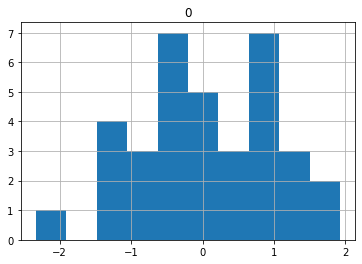

In [35]:
pd.DataFrame(results.get_influence().resid_studentized_internal).hist()

Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     32.23
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           6.41e-11
Time:                        19:42:35   Log-Likelihood:                 4.6493
No. Observations:                  35   AIC:                             18.70
Df Residuals:                      21   BIC:                             40.48
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1368      0.

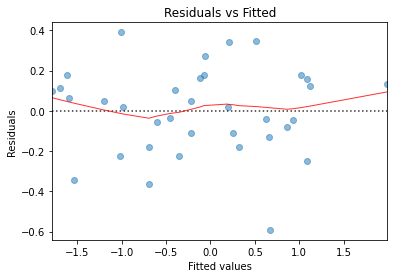

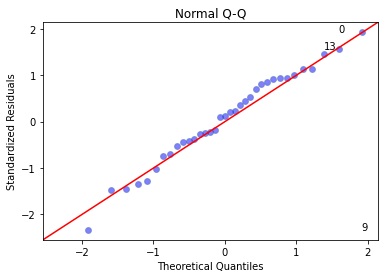

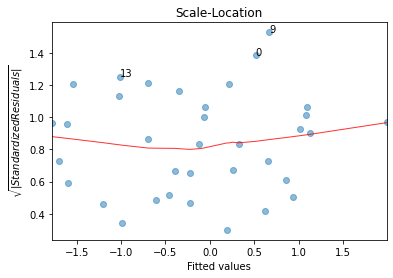

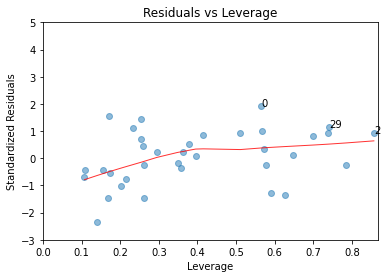

In [36]:
linear_plot = Plot.LinearRegressionResidualPlot(data_set_wConstant.values, pt_y_train.values)
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))


,University,Doctors,Traf Deaths,Income,Infant Mort,Unemployed,Population,Crime,White,University^2,...,Unemployed^2,Unemployed Population,Unemployed Crime,Unemployed White,Population^2,Population Crime,Population White,Crime^2,Crime White,White^2
18,-0.430539,0.174900,-0.448391,-0.743984,-0.339748,0.128253,-1.274544,-2.465781,1.965169,0.185364,...,0.016449,-0.163463,-0.316243,0.252038,1.624462,3.142746,-2.504694,6.080076,-4.845676,3.861888e+00
39,-0.853772,-0.659746,1.506083,-1.062582,0.923564,1.419379,-0.483133,1.682664,-0.700253,0.728926,...,2.014637,-0.685749,2.388339,-0.993925,0.233418,-0.812951,0.338316,2.831359,-1.178291,4.903548e-01
11,-0.776927,-2.185079,0.534638,-0.589949,0.029414,-0.283374,-1.219955,-1.203813,1.655856,0.603616,...,0.080301,0.345703,0.341129,-0.469226,1.488291,1.468598,-2.020070,1.449165,-1.993341,2.741859e+00
21,-0.601139,-0.265207,-1.019705,-0.438710,0.403842,2.763435,0.306008,0.763888,0.000922,0.361368,...,7.636576,0.845632,2.110955,0.002548,0.093641,0.233755,0.000282,0.583525,0.000704,8.503764e-07
47,-2.735000,-0.612200,1.523984,-2.283361,0.403842,-0.764781,-1.128527,-0.876218,1.639275,7.480224,...,0.584890,0.863076,0.670115,-1.253686,1.273574,0.988836,-1.849966,0.767758,-1.436362,2.687221e+00
2,-0.502995,-1.107118,0.730269,-0.110789,-0.261523,0.211956,-0.126558,0.518381,0.518647,0.253004,...,0.044925,-0.026825,0.109874,0.109930,0.016017,-0.065605,-0.065639,0.268719,0.268857,2.689948e-01
33,-0.084308,-0.371064,0.107311,-0.887392,-0.760997,-1.623537,-1.486312,-2.196807,1.156735,0.007108,...,2.635872,2.413082,3.566598,-1.878001,2.209123,3.265141,-1.719268,4.825963,-2.541123,1.338035e+00


,Poverty,0
18,NaN,NaN
39,NaN,NaN
11,NaN,NaN
21,NaN,NaN
47,NaN,NaN
2,NaN,NaN
33,NaN,NaN


Mean Absolute Error
Poverty    1.26545
dtype: float64


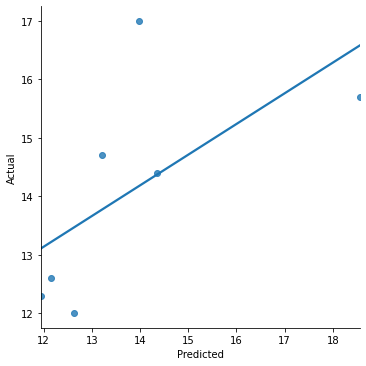

In [48]:
#
y_train_original = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(pt_y_train)),index=y_train.index,columns=y_train.columns)
y_train_predicted = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(np.array(results.fittedvalues).reshape(-1,1))),index=y_train.index,columns=y_train.columns)

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))

y_valid_ss_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_ss.predict(temp_valid[ss_sortedFeatures]))),index=y_valid.index,columns=[target])
# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid-y_valid_ss_fitted)))

#temp = pd.concat([y_train_predicted,y_train_original],axis=1)
temp = pd.concat([y_valid_ss_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean Absolute Error
Poverty    1.260093
dtype: float64


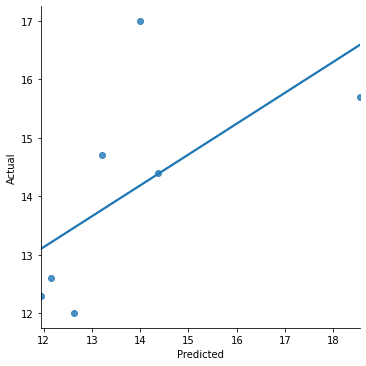

In [54]:
#model_Best = ElasticNet(alpha=best['alpha'], l1_ratio=best['lambda'])

ENBestResults = model_eb.fit(x_train_inter[best['features']], pt_y_train)

ENBestFitted = pd.DataFrame(model_eb.predict(x_train_inter[best['features']]),index=x_train_inter.index, columns = [target])

y_train_original = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(pt_y_train)),index=y_train.index,columns=y_train.columns)
y_train_predicted = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(np.array(ENBestFitted).reshape(-1,1))),index=y_train.index,columns=y_train.columns)

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))

y_valid_eb_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(np.array(model_eb.predict(temp_valid[best['features']]).reshape(-1,1)))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_eb_fitted-y_valid)))

temp = pd.concat([y_valid_eb_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

,Income,Infant Mort,Population,White,Infant Mort Unemployed,Unemployed Crime
18,-0.743984,-0.339748,-1.274544,1.965169,-0.043574,-0.316243
39,-1.062582,0.923564,-0.483133,-0.700253,1.310887,2.388339
11,-0.589949,0.029414,-1.219955,1.655856,-0.008335,0.341129
21,-0.438710,0.403842,0.306008,0.000922,1.115990,2.110955
47,-2.283361,0.403842,-1.128527,1.639275,-0.308850,0.670115
2,-0.110789,-0.261523,-0.126558,0.518647,-0.055431,0.109874
33,-0.887392,-0.760997,-1.486312,1.156735,1.235507,3.566598


Mean Absolute Error
Poverty    0.945188
dtype: float64


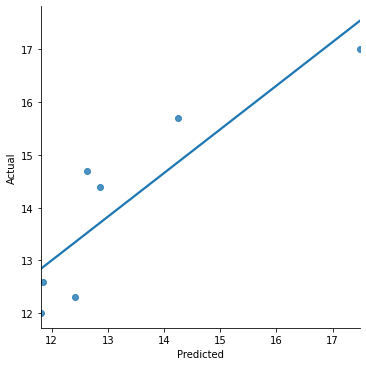

In [56]:
#model_Parse = ElasticNet(alpha=parse['alpha'], l1_ratio=parse['lambda'])

ENParseResults = model_ep.fit(x_train_inter[parse['features']], pt_y_train)

ENParseFitted = pd.DataFrame(model_ep.predict(x_train_inter[parse['features']]),index=x_train_inter.index,columns=[target])

y_train_original = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(pt_y_train)),index=y_train.index,columns=y_train.columns)
y_train_predicted = pd.DataFrame(ss_y_train.inverse_transform(pt_y_train_fit.inverse_transform(np.array(ENParseFitted).reshape(-1,1))),index=y_train.index,columns=y_train.columns)

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))

y_valid_ep_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(np.array(model_ep.predict(temp_valid[parse['features']]).reshape(-1,1)))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_ep_fitted-y_valid)))

temp = pd.concat([y_valid_ep_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [60]:
y_valid_rr_ss_fitted=y_valid

Mean MAE: 0.225 (0.067)
Mean Absolute Error
Poverty    1.170406
dtype: float64


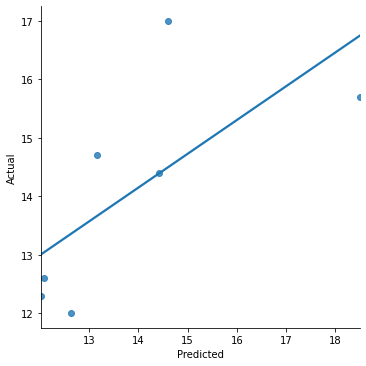

In [61]:
#robust regression using ss
# define the model
model_rr_ss = RANSACRegressor()
# evaluate model
Rresults_ss = evaluate_model(x_train_inter[ss_sortedFeatures], pt_y_train, model_rr_ss)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_ss), std(Rresults_ss)))
# plot the line of best fit
Rresults_ss = model_rr_ss.fit(x_train_inter[ss_sortedFeatures],pt_y_train)
RFitted_ss = model_rr_ss.predict(x_train_inter[ss_sortedFeatures])

temp_all = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X)),index=X.index,columns=X.columns)),index=X.index,columns=interaction.get_feature_names(input_features=X.columns))
RFitted_ss_all = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_ss.predict(temp_all[ss_sortedFeatures])))

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))
y_valid_rr_ss_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_ss.predict(temp_valid[ss_sortedFeatures]))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_ss_fitted-y_valid)))

temp = pd.concat([y_valid_rr_ss_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean MAE: 0.195 (0.065)
Mean Absolute Error
Poverty    1.26545
dtype: float64


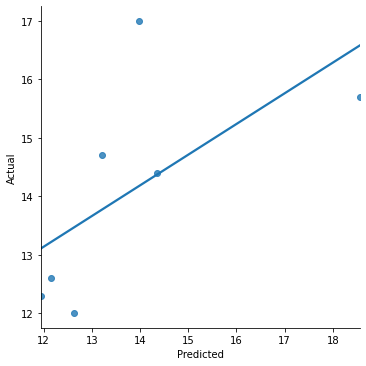

In [62]:

#robust regression using best
# define the model
model_rr_best = RANSACRegressor()
# evaluate model
Rresults_best = evaluate_model(x_train_inter[best['features']], pt_y_train, model_rr_best)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_best), std(Rresults_best)))
# plot the line of best fit
Rresults_best = model_rr_best.fit(x_train_inter[best['features']],pt_y_train)
RFitted_best = model_rr_best.predict(x_train_inter[best['features']])

temp_all = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X)),index=X.index,columns=X.columns)),index=X.index,columns=interaction.get_feature_names(input_features=X.columns))
RFitted_best_all = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_best.predict(temp_all[best['features']])))

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))
y_valid_rr_best_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_best.predict(temp_valid[best['features']]))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_best_fitted-y_valid)))

temp = pd.concat([y_valid_rr_best_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

Mean MAE: 0.199 (0.028)
Mean Absolute Error
Poverty    0.942698
dtype: float64


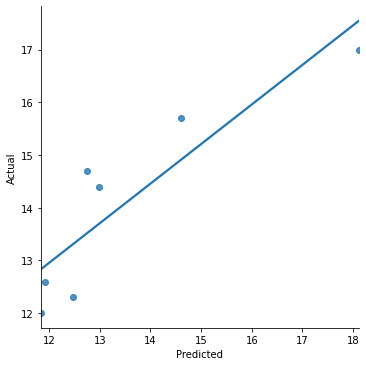

In [63]:

#robust regression using best
# define the model
model_rr_parse = RANSACRegressor()
# evaluate model
Rresults_parse = evaluate_model(x_train_inter[best['features']], pt_y_train, model_rr_parse)
print('Mean MAE: %.3f (%.3f)' % (mean(Rresults_parse), std(Rresults_parse)))
# plot the line of best fit
Rresults_parse = model_rr_parse.fit(x_train_inter[parse['features']],pt_y_train)
RFitted_parse = model_rr_parse.predict(x_train_inter[parse['features']])

temp_all = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X)),index=X.index,columns=X.columns)),index=X.index,columns=interaction.get_feature_names(input_features=X.columns))
RFitted_parse_all = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_parse.predict(temp_all[parse['features']])))

temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))
y_valid_rr_parse_fitted = pd.DataFrame(ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_rr_parse.predict(temp_valid[parse['features']]))),index=y_valid.index,columns=[target])

# summarize prediction
print("Mean Absolute Error")
print(mean(absolute(y_valid_rr_parse_fitted-y_valid)))

temp = pd.concat([y_valid_rr_parse_fitted,y_valid],axis=1)
temp.columns = ['Predicted','Actual']

sns.lmplot(x="Predicted",
           y="Actual", 
           ci=None,
           data=temp);

In [64]:
temp_valid = pd.DataFrame(interaction.fit_transform(pd.DataFrame(pt_X_train_fit.transform(ss_X_train_scale_fit.transform(X_valid)),index=X_valid.index,columns=X_valid.columns)),index=X_valid.index,columns=interaction.get_feature_names(input_features=X_valid.columns))
y_valid_ss_fitted = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_ss.predict(temp_valid[ss_sortedFeatures])))
y_valid_eb_fitted = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_eb.predict(temp_valid[best['features']]).reshape(-1, 1)))
y_valid_ep_fitted = ss_y_train_scale_fit.inverse_transform(pt_y_train_fit.inverse_transform(model_ep.predict(temp_valid[parse['features']]).reshape(-1, 1)))

In [65]:
print("OLS SS: " + str(mean(absolute(np.array(y_valid)-y_valid_ss_fitted))))
print("EN best: " + str(mean(absolute(np.array(y_valid)-y_valid_eb_fitted))))
print("EN parse: " + str(mean(absolute(np.array(y_valid)-y_valid_ep_fitted))))

print("RR SS: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_ss_fitted))))
print("RR best: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_best_fitted))))
print("RR parse: " + str(mean(absolute(np.array(y_valid)-y_valid_rr_parse_fitted))))

OLS SS: 1.2654498301666688
EN best: 1.2600925311345483
EN parse: 0.9451881508366071
RR SS: Poverty    1.170406
dtype: float64
RR best: Poverty    1.26545
dtype: float64
RR parse: Poverty    0.942698
dtype: float64


In [66]:
print("RR parse: " + str(mean(absolute(np.array(y)-RFitted_parse_all))))
print("RR ss: " + str(mean(absolute(np.array(y)-RFitted_ss_all))))

RR parse: 0.731318582174693
RR ss: 0.7026556814815261
